In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary
import numpy as np
import gymnasium as gym
import torch.autograd
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import sys
import cv2
import wandb
import random

# For Replay Buffer
import random
from collections import deque

### Model Definition

In [2]:
class Critic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)

    def forward(self, state, action):
        """
        Params state and actions are torch tensors
        """
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

class Actor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, learning_rate = 3e-4):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)

    def forward(self, state):
        """
        Param state is a torch tensor
        """
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))

        return x

class DDPGagent:

    def __init__(self, env, hidden_size=256, actor_learning_rate=1e-4, critic_learning_rate=1e-3, gamma=0.99, tau=1e-2, max_memory_size=50000,angle_threshold = 20,angle_threshold_epsilon=5):
        # Params
        self.num_states = env.observation_space.shape[0]
        self.num_actions = env.action_space.shape[0]
        self.gamma = gamma
        self.tau = tau
        self.env = env
        self.angle_threshold = angle_threshold
        self.angle_threshold_epsilon = angle_threshold_epsilon

        # Env Config
        self.Tm = 2
        self.m = 1
        self.l = 1
        self.g = 9.81

        # Networks
        self.actor = Actor(self.num_states, hidden_size, self.num_actions)
        self.actor_target = Actor(self.num_states, hidden_size, self.num_actions)
        self.critic = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)
        self.critic_target = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)

        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)

        # Training
        self.memory = Memory(max_memory_size)
        self.critic_criterion  = nn.MSELoss()
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=actor_learning_rate)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_learning_rate)

    def get_action(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        action = self.actor.forward(state)
        action = action.detach().numpy()[0,0]
        assert self.env.action_space.high[0]==2

        return self.env.action_space.high[0]*action # Coz the output of the policy network is between -1,1 (added on 4/10/2023)

    # def is_safe_state(self,state):
    #     '''
    #     The arguments must be in radians
    #     '''
    #     theta0 = self.angle_threshold*np.pi/180
    #     theta = np.arctan2(state[1],state[0])
    #     omega = state[2]

    #     if abs(theta)>theta0:
    #         return False
    #     else:
    #         if omega - f1(theta,theta0)<0 and omega-f2(theta,theta0)>0:
    #             return True
    #         else:
    #             return False

    def is_safe_state2(self,state):
        '''
        This marks the boundary of the marginally safe state space
        '''

        Tm = self.Tm
        m = self.m
        l = self.l
        g = self.g

        theta0 = self.angle_threshold*np.pi/180
        theta = np.arctan2(state[1],state[0])
        omega = state[2]

        if abs(theta)>theta0:
            return False

        if omega>=0:
            h = -Tm*(theta0-theta) + (1/6)*m*l*l*omega**2 - (1/2)*m*g*l*(np.cos(theta0)-np.cos(theta))
        else:
            h = -Tm*(theta0+theta) + (1/6)*m*l*l*omega**2 - (1/2)*m*g*l*(np.cos(theta0)-np.cos(theta))

        if h<=0:
            return True
        else:
            return False

    def is_marginally_safe(self,state):
        '''
        This is for the states between the inner and outer region representing the buffer region of marginally safe region
        '''
        if self.is_safe_state_shrunk(state)==False and self.is_safe_state2(state)==True:
            return True
        else:
            return False

    def is_safe_state_shrunk(self,state):
        '''
        This marks the boundary of the inner shrunk safe state space
        '''
        Tm = self.Tm
        m = self.m
        l = self.l
        g = self.g

        theta0 = self.angle_threshold_epsilon*np.pi/180
        theta = np.arctan2(state[1],state[0])
        omega = state[2]

        if abs(theta)>theta0:
            return False

        if omega>=0:
            h = -Tm*(theta0-theta) + (1/6)*m*l*l*omega**2 - (1/2)*m*g*l*(np.cos(theta0)-np.cos(theta))
        else:
            h = -Tm*(theta0+theta) + (1/6)*m*l*l*omega**2 - (1/2)*m*g*l*(np.cos(theta0)-np.cos(theta))

        if h<=0:
            return True
        else:
            return False


    def is_safe(self,state,action):

        assert len(state)==3

        angle = np.arctan2(state[1],state[0])*180/np.pi
        angle_threshold = self.angle_threshold
        safety = 1

        # if abs(angle)<angle_threshold:
        if abs(angle)<self.angle_threshold_epsilon:
            if action*state[2]>0:
                safety = 0

        else:
            if action*angle>=0: #if both action and the angle have same sign
                safety = 0
        # if abs(angle)>angle_threshold:
        #     if action*angle>0: #if both action and the angle have same sign
        #         safety = 0


        return safety

    def get_safe_action(self,state,action,epsilon=0.1):

        # assert len(state)==3

        # safety = self.is_safe(state,action)
        # if safety:
        #     return action
        # else:

        angle = np.arctan2(state[1],state[0])*180/np.pi
        action_range = self.env.action_space.high[0]

        # if abs(state[2])>0:
        #     action = -action_range
        # else:
        #     action = action_range

        if abs(angle)<self.angle_threshold_epsilon:
            if state[2]>0:
                action = -action_range
            elif state[2]<0:
                action = action_range
            else:
                action = 0

        else:
            if angle>0:
                action = -action_range
            else:
                action = action_range

        return np.array([action])

            # if action>0:
            #     return np.array([-self.env.action_space.high[0]])

            # elif action<0:
            #     return np.array([self.env.action_space.high[0]])

            # elif action==0:
            #     if angle>0:
            #         return np.array([-self.env.action_space.high[0]])
            #     else:
            #         return np.array([self.env.action_space.high[0]])


            # resolution = 100
            # zero_tol = 0.01
            # action_range = self.env.action_space.high[0]

            # probab = np.random.uniform(0,1)
            # if probab<epsilon:
            #     if action[0]<=0:
            #         action = np.random.uniform(zero_tol,action_range)

            #     else:
            #         action = np.random.uniform(-zero_tol,-action_range)

            #     return np.array([action])


            # if action[0]<=0:
            #     safe_action_space = torch.linspace(zero_tol,action_range,resolution).unsqueeze(1)
            #     #We need the safe action set in the direction opposite to angle deviation

            # else:
            #     safe_action_space = torch.linspace(-zero_tol,-action_range,resolution).unsqueeze(1)



            # state_tensor = Variable(torch.from_numpy(state).float().unsqueeze(0))
            # state_concat = torch.cat([state_tensor] * resolution, dim=0) #Stacked Tensor with same state value to pass into critic

            # Qvals = self.critic.forward(state_concat, safe_action_space)
            # action_index = torch.argmax(Qvals)

            # #action is a (1,1) shaped ndarray below
            # action = safe_action_space[action_index].detach().numpy() #finding the action with highest Q value
            # return action

    def update(self, batch_size):
        states, actions, rewards, next_states, _ = self.memory.sample(batch_size)
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)

        # Critic loss
        Qvals = self.critic.forward(states, actions)
        next_actions = self.actor_target.forward(next_states)
        next_Q = self.critic_target.forward(next_states, next_actions.detach())
        Qprime = rewards + self.gamma * next_Q
        critic_loss = self.critic_criterion(Qvals, Qprime)

        # Actor loss
        policy_loss = -self.critic.forward(states, self.actor.forward(states)).mean()

        # update networks
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # update target networks
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

class Memory:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)

        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

    def __len__(self):
        return len(self.buffer)

class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu

    def evolve_state(self):
        # Update the noise state according to the Ornstein-Uhlenbeck process
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state

    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)

class NormalizedEnv(gym.ActionWrapper):
    """ Wrap action """

    def _action(self, action):
        act_k = (self.action_space.high - self.action_space.low)/ 2.
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k * action + act_b

    def _reverse_action(self, action):
        act_k_inv = 2./(self.action_space.high - self.action_space.low)
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k_inv * (action - act_b)

def get_angle(state):
    return (np.arctan2(state[1],state[0])*180/np.pi)

### Training

In [4]:
def run_algo(config_dict):
    batch_size = config_dict['batch_size']
    hidden_size = config_dict['hidden_size']
    num_episodes = config_dict['num_episodes']
    num_episodes_test = config_dict['num_episodes_test']
    angle_threshold = config_dict['angle_threshold']
    angle_threshold_start = config_dict['angle_threshold_start']
    velocity_threshold_start = config_dict['velocity_threshold_start']
    ensure_safe_set = config_dict['ensure_safe_set'] # Safe, Partially Safe, No Safe Action Set
    safety_ratio = config_dict['safety_ratio']
    num_time_steps = config_dict['num_time_steps']
    safe_action_epsilon = config_dict['safe_action_epsilon']
    angle_threshold_epsilon = config_dict['angle_threshold_epsilon']

    assert ensure_safe_set == 'safe' or ensure_safe_set == 'partially_safe' or ensure_safe_set =='no safe set'

    if config_dict['wandb_log']:
        wandb.init(
            # set the wandb project where this run will be logged
            project="ddpg",

            # track hyperparameters and run metadata
            config=config_dict
        )

    env = gym.make("Pendulum-v1",render_mode = 'rgb_array')
    agent = DDPGagent(env,hidden_size=hidden_size,angle_threshold = angle_threshold,angle_threshold_epsilon=angle_threshold_epsilon)
    noise = OUNoise(env.action_space)

    ############################# TRAINING ##################################
    rewards = []

    starting_angles = [] #The angle with which the episode starts
    starting_velocities = [] #The velocity with which the episode starts
    average_action_list = [] #The average torque in an episode
    average_angle_list = []  #The average angle in an episode
    average_reward_list = [] #The average reward in an episode
    steps_list = []          #Stores the number of steps in each episode
    average_safe_action_list = [] #Stores the percentage of safe action generated before the safety layer intervention
    safe_state_percent_list = []
    marginally_safe_state_percent_list = []
    human_provided_safe_state_percent_list = []

    action_trajectories = {} # Stores the action trajectory for each episode
    safe_action_flag_trajectories = {}
    state_type_trajectories = {}
    angle_trajectories = {}  # Stores the angle trajectory for each episode
    action_trajectories_after_safety_layer = {} # Stores the velocity trajectory for each episode
    velocity_trajectories = {}
    # safety_violations_list = []


    episode = 0
    while episode < num_episodes:


        state,_ = env.reset()

        if agent.is_safe_state2(state)==False:
            # Ensuring that the episode starts in a safe state
            continue
        else:
            action_trajectory = []
            safe_action_flag_trajectory = []
            state_type_trajectory = []
            angle_trajectory = []
            velocity_trajectory = []
            action_trajectory_after_safety_layer = []

            episode += 1
            starting_angle = (np.arctan2(state[1],state[0])*180/np.pi)
            starting_velocity = state[2]


            starting_angles.append(starting_angle) # Data Collection
            starting_velocities.append(starting_velocity)

            assert abs(starting_angle)<angle_threshold

            noise.reset()
            episode_reward = 0
            within_threshold_count = 0
            action_within_threshold = 0
            safe_action_count_within_threshold = 0
            angle_sum = 0
            action_sum = 0
            step = 0
            num_safe_actions = 0
            num_safe_actions_old = 0
            num_safe_state = 0
            num_marginally_safe_state = 0
            num_human_provided_safe_state = 0

            # safety_violations = 0

            while True:
                step+=1
                angle = np.arctan2(state[1],state[0])*180/np.pi
                angle_sum += abs(angle)

                action = agent.get_action(state) # This is scalar
                action = noise.get_action(action, step) # This is a numpy array

                action_trajectory.append(action[0])
                angle_trajectory.append(angle)
                velocity_trajectory.append(state[2])

                # if agent.is_safe(state,action[0])==1:
                #     num_safe_actions+=1

                # if action*angle<=0: #Must be less than or equal to i.e complement of action*angle>0 for unsafe
                #     num_safe_actions_old+=1

                
                if agent.is_safe_state2(state):
                    num_human_provided_safe_state+=1
                    pass
                else:
                    print('Not Safe State',step)

                if ensure_safe_set=='safe':
                    if agent.is_safe_state_shrunk(state):
                        pass
                    else:
                        action = agent.get_safe_action(state,action,safe_action_epsilon)
                    # assert agent.is_safe(state,action)==1

                elif ensure_safe_set == 'partially_safe':
                    if np.random.uniform(0,1) < safety_ratio:
                        if agent.is_safe_state2(state):
                            pass
                        else:
                            action = agent.get_safe_action(state,action,safe_action_epsilon)



                ##### logging variables #######
                if agent.is_safe(state,action[0])==1:
                    num_safe_actions+=1
                safe_action_flag_trajectory.append(agent.is_safe(state,action[0]))

                action_trajectory_after_safety_layer.append(action[0])

                action_sum += abs(action[0])

                if agent.is_safe_state_shrunk(state):
                    state_type = 2 #2 indicates that the state is completely safe and is in the shrunk conservative safe set 
                    num_safe_state+=1

                elif agent.is_marginally_safe(state):
                    num_marginally_safe_state+=1
                    state_type = 1 #1 indicates that the state is marginally safe

                elif agent.is_safe_state2(state)==False:
                    state_type = 0 # It is outside the human specified safe set
                
                state_type_trajectory.append(state_type)


                ###############################
                new_state, reward, done, truncated,_ = env.step(action)

                if abs(get_angle(new_state))>angle_threshold:
                    # safety_violations+=1
                    done = True

                agent.memory.push(state, action, reward, new_state, done)

                if len(agent.memory) > batch_size:
                    agent.update(batch_size)

                state = new_state
                episode_reward += reward

                if done or truncated:


                    # Logging
                    average_action = action_sum/step
                    average_angle = angle_sum/step
                    average_reward = episode_reward/step
                    average_num_safe_action = num_safe_actions/step
                    # average_num_safe_action_old = num_safe_actions_old/step
                    average_num_safe_state = num_safe_state/step
                    average_num_marginally_safe_state = num_marginally_safe_state/step
                    average_num_human_provided_safe_state = num_human_provided_safe_state/step

                    steps_list.append(step)
                    average_angle_list.append(average_angle)
                    average_action_list.append(average_action)
                    average_reward_list.append(average_reward)
                    average_safe_action_list.append(average_num_safe_action*100)
                    safe_state_percent_list.append(average_num_safe_state*100)
                    marginally_safe_state_percent_list.append(average_num_marginally_safe_state*100)
                    human_provided_safe_state_percent_list.append(average_num_human_provided_safe_state*100)
                    # safety_violations_list.append(safety_violations)

                    if config_dict['wandb_log']:

                        wandb.log({'Steps':step,
                                   'Percent Safe State':average_num_safe_state*100,
                                   'Percent Marginally Safe State':average_num_marginally_safe_state*100,
                                   'Percent Human Provided Safe State':average_num_human_provided_safe_state*100,
                                   'Average Reward':average_reward,
                                   'Average Angle':average_angle,
                                   'Average Action (Torque)':average_action,
                                   'Starting Angle':starting_angle,
                                   'Starting Velocity':starting_velocity})
                                #    'Safety Violations':safety_violations})

                    print("Episode: {} | Steps: {} | Average Reward: {:.2f} | Average Angle: {:.2f} | Average Action (Torque): {:.2f} |  Starting Angle: {:.2f} "
                          "| Starting Velocity: {:.2f} | Percent Safe State: {:.2f} | Percent Marginally Safe State: {:.2f} | Human Provided Safe State: {:.2f}".format(episode,step,
                                                                                                                                                                        average_reward,
                                                                                                                                                                        average_angle,
                                                                                                                                                                        average_action,
                                                                                                                                                                        starting_angle,
                                                                                                                                                                        starting_velocity,
                                                                                                                                                                        average_num_safe_state*100,
                                                                                                                                                                        average_num_marginally_safe_state*100,
                                                                                                                                                                        average_num_human_provided_safe_state*100))

                    break

            action_trajectories[episode] = action_trajectory
            angle_trajectories[episode] = angle_trajectory
            velocity_trajectories[episode] = velocity_trajectory
            action_trajectories_after_safety_layer[episode] = action_trajectory_after_safety_layer
            safe_action_flag_trajectories[episode] = safe_action_flag_trajectory
            state_type_trajectories[episode] = state_type_trajectory








    plt.plot(steps_list)
    # plt.plot(average_reward_list)
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    plt.show()

    info_train = {'starting_angles':starting_angles,
            'average_angle':average_angle_list,
            'average_action':average_action_list,
            'steps_list':steps_list,
            'average_rewards':average_reward_list,
            'percent_safe_action':average_num_safe_action*100,
            'safe_state_percent_list':safe_state_percent_list,
            'marginally_safe_state_percent_list':marginally_safe_state_percent_list,
            'human_provided_safe_state_percent_list':human_provided_safe_state_percent_list,
                  
            'state_type_trajectories':state_type_trajectories,
            'action_trajectories':action_trajectories,
            'angle_trajectories':angle_trajectories,
            'velocity_trajectories':velocity_trajectories,
            'action_trajectories_after_safety_layer':action_trajectories_after_safety_layer,
            'safe_action_flag_trajectories':safe_action_flag_trajectories}


############################### TESTING PHASE #############################

    starting_angles = [] #The angle with which the episode starts
    starting_velocities = [] #The velocity with which the episode starts
    average_action_list = [] #The average torque in an episode
    average_angle_list = []  #The average angle in an episode
    average_reward_list = [] #The average reward in an episode
    steps_list = []          #Stores the number of steps in each episode
    average_safe_action_list = [] #Stores the percentage of safe action generated before the safety layer intervention
    safe_state_percent_list = []
    marginally_safe_state_percent_list = []
    human_provided_safe_state_percent_list = []

    action_trajectories = {} # Stores the action trajectory for each episode
    safe_action_flag_trajectories = {}
    state_type_trajectories = {}
    angle_trajectories = {}  # Stores the angle trajectory for each episode
    action_trajectories_after_safety_layer = {} # Stores the velocity trajectory for each episode
    velocity_trajectories = {}
    # safety_violations_list = []


    episode = 0
    while episode < num_episodes_test:


        state,_ = env.reset()

        if agent.is_safe_state2(state)==False:
            # Ensuring that the episode starts in a safe state
            continue
        else:
            action_trajectory = []
            safe_action_flag_trajectory = []
            state_type_trajectory = []
            angle_trajectory = []
            velocity_trajectory = []
            action_trajectory_after_safety_layer = []

            episode += 1
            starting_angle = (np.arctan2(state[1],state[0])*180/np.pi)
            starting_velocity = state[2]


            starting_angles.append(starting_angle) # Data Collection
            starting_velocities.append(starting_velocity)

            assert abs(starting_angle)<angle_threshold

            noise.reset()
            episode_reward = 0
            within_threshold_count = 0
            action_within_threshold = 0
            safe_action_count_within_threshold = 0
            angle_sum = 0
            action_sum = 0
            step = 0
            num_safe_actions = 0
            num_safe_actions_old = 0
            num_safe_state = 0
            num_marginally_safe_state = 0
            num_human_provided_safe_state = 0

            # safety_violations = 0

            while True:
                step+=1
                angle = np.arctan2(state[1],state[0])*180/np.pi
                angle_sum += abs(angle)

                action = agent.get_action(state) # This is scalar
                action = noise.get_action(action, step) # This is a numpy array

                action_trajectory.append(action[0])
                angle_trajectory.append(angle)
                velocity_trajectory.append(state[2])

                # if agent.is_safe(state,action[0])==1:
                #     num_safe_actions+=1

                # if action*angle<=0: #Must be less than or equal to i.e complement of action*angle>0 for unsafe
                #     num_safe_actions_old+=1

                
                if agent.is_safe_state2(state):
                    num_human_provided_safe_state+=1
                    pass
                else:
                    print('Not Safe State',step)

                # if ensure_safe_set=='safe':
                #     if agent.is_safe_state_shrunk(state):
                #         pass
                #     else:
                #         action = agent.get_safe_action(state,action,safe_action_epsilon)
                #     # assert agent.is_safe(state,action)==1

                # elif ensure_safe_set == 'partially_safe':
                #     if np.random.uniform(0,1) < safety_ratio:
                #         if agent.is_safe_state2(state):
                #             pass
                #         else:
                #             action = agent.get_safe_action(state,action,safe_action_epsilon)



                ##### logging variables #######
                if agent.is_safe(state,action[0])==1:
                    num_safe_actions+=1
                safe_action_flag_trajectory.append(agent.is_safe(state,action[0]))

                action_trajectory_after_safety_layer.append(action[0])

                action_sum += abs(action[0])

                if agent.is_safe_state_shrunk(state):
                    state_type = 2 #2 indicates that the state is completely safe and is in the shrunk conservative safe set 
                    num_safe_state+=1

                elif agent.is_marginally_safe(state):
                    num_marginally_safe_state+=1
                    state_type = 1 #1 indicates that the state is marginally safe

                elif agent.is_safe_state2(state)==False:
                    state_type = 0 # It is outside the human specified safe set
                
                state_type_trajectory.append(state_type)


                ###############################
                new_state, reward, done, truncated,_ = env.step(action)

                if abs(get_angle(new_state))>angle_threshold:
                    # safety_violations+=1
                    done = True

                # agent.memory.push(state, action, reward, new_state, done)

                # if len(agent.memory) > batch_size:
                #     agent.update(batch_size)

                state = new_state
                episode_reward += reward

                if done or truncated:


                    # Logging
                    average_action = action_sum/step
                    average_angle = angle_sum/step
                    average_reward = episode_reward/step
                    average_num_safe_action = num_safe_actions/step
                    # average_num_safe_action_old = num_safe_actions_old/step
                    average_num_safe_state = num_safe_state/step
                    average_num_marginally_safe_state = num_marginally_safe_state/step
                    average_num_human_provided_safe_state = num_human_provided_safe_state/step

                    steps_list.append(step)
                    average_angle_list.append(average_angle)
                    average_action_list.append(average_action)
                    average_reward_list.append(average_reward)
                    average_safe_action_list.append(average_num_safe_action*100)
                    safe_state_percent_list.append(average_num_safe_state*100)
                    marginally_safe_state_percent_list.append(average_num_marginally_safe_state*100)
                    human_provided_safe_state_percent_list.append(average_num_human_provided_safe_state*100)
                    # safety_violations_list.append(safety_violations)

                    if config_dict['wandb_log']:

                        wandb.log({'Steps':step,
                                   'Percent Safe State':average_num_safe_state*100,
                                   'Percent Marginally Safe State':average_num_marginally_safe_state*100,
                                   'Percent Human Provided Safe State':average_num_human_provided_safe_state*100,
                                   'Average Reward':average_reward,
                                   'Average Angle':average_angle,
                                   'Average Action (Torque)':average_action,
                                   'Starting Angle':starting_angle,
                                   'Starting Velocity':starting_velocity})
                                #    'Safety Violations':safety_violations})

                    print("Episode: {} | Steps: {} | Average Reward: {:.2f} | Average Angle: {:.2f} | Average Action (Torque): {:.2f} |  Starting Angle: {:.2f} "
                          "| Starting Velocity: {:.2f} | Percent Safe State: {:.2f} | Percent Marginally Safe State: {:.2f} | Human Provided Safe State: {:.2f}".format(episode,step,
                                                                                                                                                                        average_reward,
                                                                                                                                                                        average_angle,
                                                                                                                                                                        average_action,
                                                                                                                                                                        starting_angle,
                                                                                                                                                                        starting_velocity,
                                                                                                                                                                        average_num_safe_state*100,
                                                                                                                                                                        average_num_marginally_safe_state*100,
                                                                                                                                                                        average_num_human_provided_safe_state*100))

                    break

            action_trajectories[episode] = action_trajectory
            angle_trajectories[episode] = angle_trajectory
            velocity_trajectories[episode] = velocity_trajectory
            action_trajectories_after_safety_layer[episode] = action_trajectory_after_safety_layer
            safe_action_flag_trajectories[episode] = safe_action_flag_trajectory
            state_type_trajectories[episode] = state_type_trajectory








    plt.plot(steps_list)
    # plt.plot(average_reward_list)
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    plt.show()

    info_test = {'starting_angles':starting_angles,
            'average_angle':average_angle_list,
            'average_action':average_action_list,
            'steps_list':steps_list,
            'average_rewards':average_reward_list,
            'percent_safe_action':average_num_safe_action*100,
            'safe_state_percent_list':safe_state_percent_list,
            'marginally_safe_state_percent_list':marginally_safe_state_percent_list,
            'human_provided_safe_state_percent_list':human_provided_safe_state_percent_list,
                  
            'state_type_trajectories':state_type_trajectories,
            'action_trajectories':action_trajectories,
            'angle_trajectories':angle_trajectories,
            'velocity_trajectories':velocity_trajectories,
            'action_trajectories_after_safety_layer':action_trajectories_after_safety_layer,
            'safe_action_flag_trajectories':safe_action_flag_trajectories}


####################$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$###################

    if config_dict['wandb_log']:
        wandb.finish()

    return agent, noise, env, info_train, info_test

Not Safe State 171
Not Safe State 172
Not Safe State 173
Not Safe State 174
Not Safe State 175
Not Safe State 176
Episode: 1 | Steps: 176 | Average Reward: -0.04 | Average Angle: 9.72 | Average Action (Torque): 1.23 |  Starting Angle: -11.08 | Starting Velocity: 0.41 | Percent Safe State: 55.11 | Percent Marginally Safe State: 41.48 | Human Provided Safe State: 96.59
Episode: 2 | Steps: 200 | Average Reward: -0.04 | Average Angle: 8.37 | Average Action (Torque): 1.22 |  Starting Angle: 18.70 | Starting Velocity: -0.29 | Percent Safe State: 54.00 | Percent Marginally Safe State: 46.00 | Human Provided Safe State: 100.00
Episode: 3 | Steps: 200 | Average Reward: -0.03 | Average Angle: 8.74 | Average Action (Torque): 0.99 |  Starting Angle: 2.16 | Starting Velocity: 0.88 | Percent Safe State: 62.00 | Percent Marginally Safe State: 38.00 | Human Provided Safe State: 100.00
Episode: 4 | Steps: 200 | Average Reward: -0.02 | Average Angle: 6.34 | Average Action (Torque): 0.65 |  Starting Angl

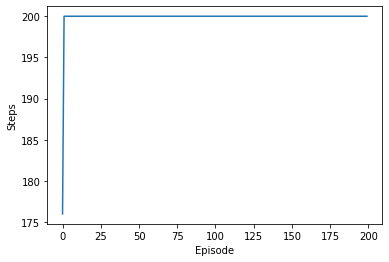

Episode: 1 | Steps: 200 | Average Reward: -0.01 | Average Angle: 1.44 | Average Action (Torque): 1.35 |  Starting Angle: 6.50 | Starting Velocity: -0.44 | Percent Safe State: 100.00 | Percent Marginally Safe State: 0.00 | Human Provided Safe State: 100.00
Episode: 2 | Steps: 200 | Average Reward: -0.01 | Average Angle: 2.14 | Average Action (Torque): 1.51 |  Starting Angle: -17.95 | Starting Velocity: -0.05 | Percent Safe State: 95.50 | Percent Marginally Safe State: 4.50 | Human Provided Safe State: 100.00
Episode: 3 | Steps: 200 | Average Reward: -0.01 | Average Angle: 1.72 | Average Action (Torque): 1.61 |  Starting Angle: 8.69 | Starting Velocity: 0.72 | Percent Safe State: 96.00 | Percent Marginally Safe State: 4.00 | Human Provided Safe State: 100.00
Episode: 4 | Steps: 200 | Average Reward: -0.01 | Average Angle: 1.42 | Average Action (Torque): 1.54 |  Starting Angle: -2.33 | Starting Velocity: -0.72 | Percent Safe State: 100.00 | Percent Marginally Safe State: 0.00 | Human Prov

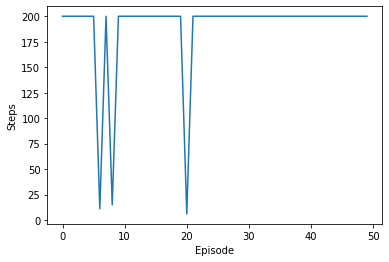

In [13]:
for i in range(1):
    config_dict = {'batch_size':128,
                'hidden_size':256,
                'angle_threshold':20,
                'angle_threshold_start':15, #An episode starts only if the initial angle is within this.
                'velocity_threshold_start':0.6,
                'num_episodes':200,
                'num_episodes_test':50,
                'ensure_safe_set':'safe',
                'safety_ratio':0.7,
                'wandb_log':False,
                'num_time_steps':200,
                'safe_action_epsilon':0.1,
                'angle_threshold_epsilon':10}

    agent, noise, env, info_train,info_test = run_algo(config_dict)

### Testing Stage

In [64]:
#### Plotting Helper Functions

Tm = 2
theta0 = 20*np.pi/180
m = 1
l = 1
g = 9.81

def f1(theta,theta0):
    theta = np.array(theta)
    if (abs(theta)>theta0).any():
        raise ValueError('Theta Value is outside safe range')
    else:
        return np.sqrt((6/(m*l**2))*(Tm*(theta0-theta)+0.5*m*g*l*(np.cos(theta0)-np.cos(theta))))

def f2(theta,theta0):
    theta = np.array(theta)

    if (abs(theta)>theta0).any():
        raise ValueError('Theta Value is outside safe range')
    else:
        return -np.sqrt((6/(m*l**2))*(Tm*(theta0+theta)+0.5*m*g*l*(np.cos(theta0)-np.cos(theta))))


def plot_safe_set(theta0,ax,color):
    theta_axis = np.linspace(-theta0,theta0,1000)

    boundary_1 = f1(theta_axis,theta0)
    boundary_2 = f2(theta_axis,theta0)

    theta_axis = theta_axis*180/np.pi

    ax.grid(True)
    ax.plot(theta_axis,boundary_1,color=color)
    ax.plot(theta_axis,boundary_2,color=color)
    ax.plot([theta_axis[0],theta_axis[0]],[boundary_1[0],boundary_2[0]],color=color)
    ax.plot([theta_axis[-1],theta_axis[-1]],[boundary_1[-1],boundary_2[-1]],color=color)
    ax.set_xlim([-35,35])
    ax.set_ylim([-4,4])
    ax.set_ylabel(r'$\dot{\theta}$ (rad/s)')
    ax.set_xlabel(r'$\theta$ (in degrees)')
    ax.set_title(r'$\theta_{0}$ = ' + str(int(round(theta0*180/np.pi,0))))

    return ax

def plot_trajectory(info,rows,cols,episodes,scatter=True,color_split_steps=2):

    episode_index = 0
    fig,axes = plt.subplots(rows,cols,figsize=(20,10))

    for i in range(rows):
        for j in range(cols):
            episode = episodes[episode_index]
            episode_index+=1


            angle_trajectory = info['angle_trajectories'][episode]
            velocity_trajectory = info['velocity_trajectories'][episode]
            state_type_trajectory = info['state_type_trajectories'][episode]
            color_coding_dict = {0:'black',1:'red',2:'green',4:'black'}
            color_coding = [color_coding_dict[i] for i in state_type_trajectory]

            ax = axes[i][j]
            theta0 = config_dict['angle_threshold']*np.pi/180
            ax = plot_safe_set(theta0,ax,color='red')


            theta0 = config_dict['angle_threshold_epsilon']*np.pi/180
            ax = plot_safe_set(theta0,ax,color='green')

            if scatter:
                for k in range(len(angle_trajectory)):
                    ax.scatter(angle_trajectory[k],velocity_trajectory[k],color=color_coding[k],s=5)


                ax.scatter(angle_trajectory[:color_split_steps+1],velocity_trajectory[:color_split_steps+1],color='cyan',s=5)

            else:
                ax.plot(angle_trajectory[:color_split_steps+1],velocity_trajectory[:color_split_steps+1],color='cyan')
                ax.plot(angle_trajectory[color_split_steps:],velocity_trajectory[color_split_steps:],color='blue')

            ax.set_title('Episode Number: {}'.format(episode))

    return ax

def plot_curves(info,episode,window):

    state_type_trajectory = info['state_type_trajectories'][episode]
    color_coding_dict = {0:'black',1:'red',2:'green',4:'black'}
    color_coding = [color_coding_dict[i] for i in state_type_trajectory]

    fig,ax = plt.subplots(2,2,figsize=(20,10))
    
    ax[0,0].plot(info['action_trajectories'][episode][window[0]:window[1]])
    ax[0,0].set_title('Torque')

    ax[1,0].plot(info['action_trajectories_after_safety_layer'][episode][window[0]:window[1]])
    ax[1,0].set_title('Torque (after safety layer)')

    ax[0,1].plot(info['angle_trajectories'][episode][window[0]:window[1]])
    ax[0,1].set_title('Angle')

    ax[1,1].plot(info['velocity_trajectories'][episode][window[0]:window[1]])
    ax[1,1].set_title('Velocity')
    plt.show()

#### Trajectories


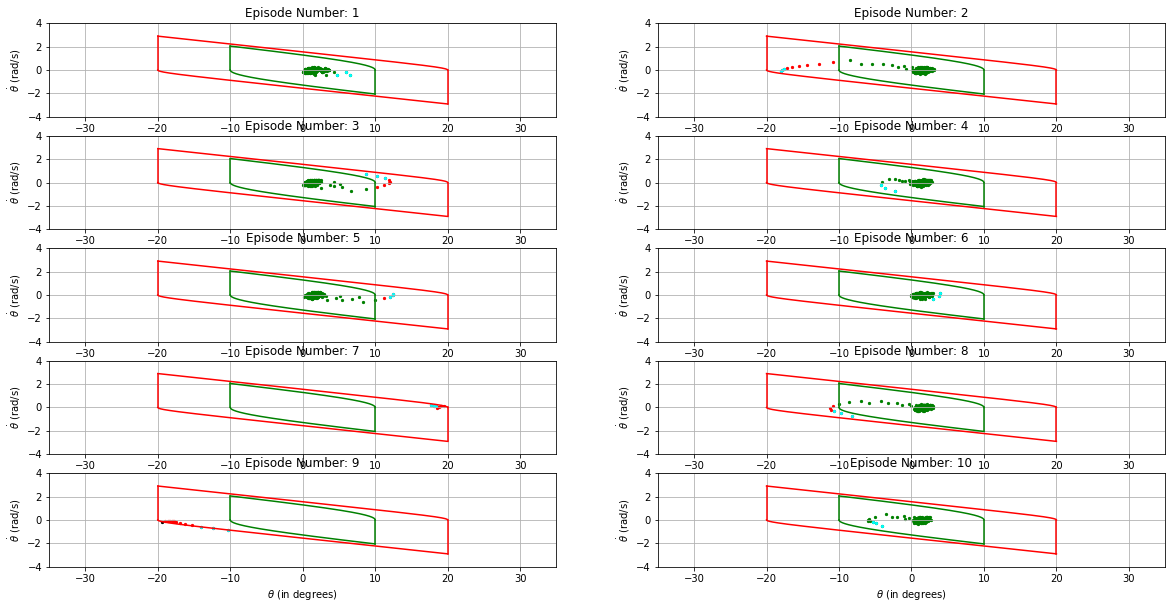

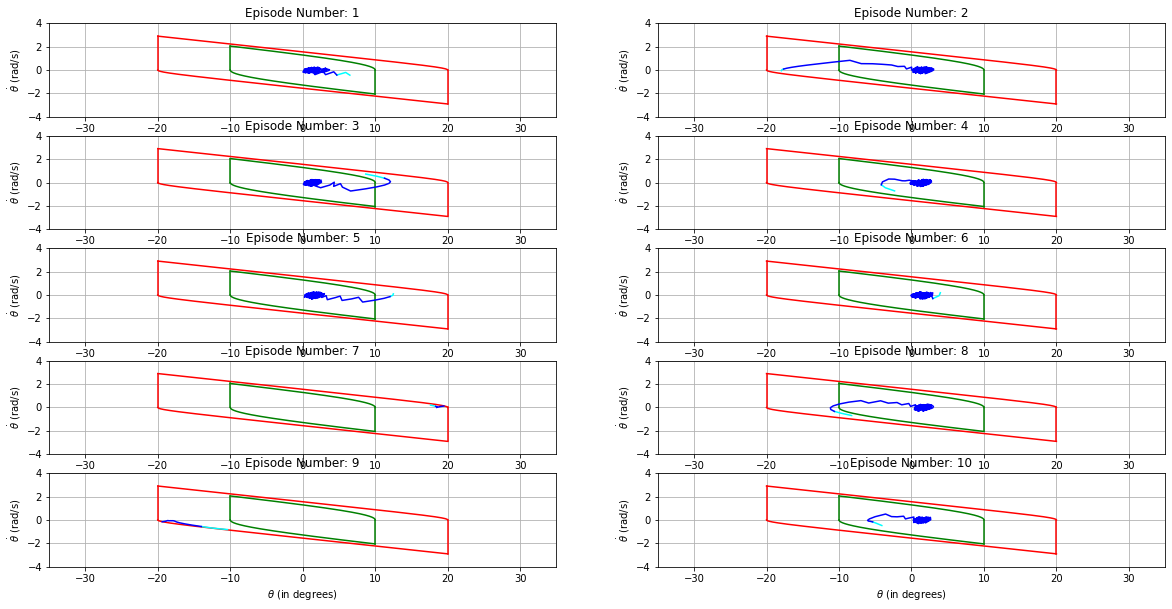

In [18]:
rows=4
cols=2
info = info_test

episodes = list(range(1,11)) # the list of episodes to visualise 1-index

ax = plot_trajectory(info,rows,cols,scatter = True, episodes=episodes)
plt.show()

ax = plot_trajectory(info,rows,cols,scatter = False, episodes=episodes)
plt.show()

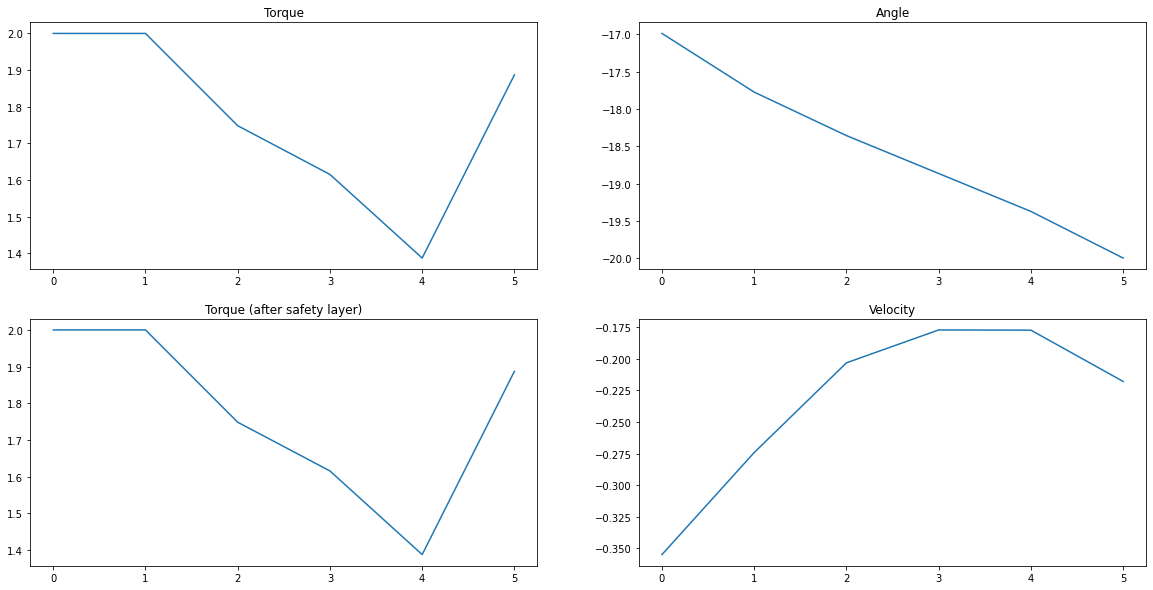

In [16]:
episode = 21
info = info_test
window = [0,200]

plot_curves(info,episode,window)

#### Distrubances

In [20]:
config_dict = {'batch_size':128,
            'hidden_size':256,
            'angle_threshold':20,
            'angle_threshold_start':15, #An episode starts only if the initial angle is within this.
            'velocity_threshold_start':0.6,
            'num_episodes':200,
            'num_episodes_test':50,

            'enable_disturbance':True,
            'ensure_safe_set':'safe',
            'safety_ratio':0.7,
            'wandb_log':False,
            'wandb_log_dist':False,
            'num_time_steps':200,
            'safe_action_epsilon':0.1,
            'angle_threshold_epsilon':10,
            'max_disturbance_steps':3}

In [42]:
def test_runs(env,agent,noise,config_dict):

    batch_size = config_dict['batch_size']
    hidden_size = config_dict['hidden_size']
    num_episodes = config_dict['num_episodes']
    num_episodes_test = config_dict['num_episodes_test']
    angle_threshold = config_dict['angle_threshold']
    angle_threshold_start = config_dict['angle_threshold_start']
    velocity_threshold_start = config_dict['velocity_threshold_start']
    ensure_safe_set = config_dict['ensure_safe_set'] # Safe, Partially Safe, No Safe Action Set
    safety_ratio = config_dict['safety_ratio']
    num_time_steps = config_dict['num_time_steps']
    safe_action_epsilon = config_dict['safe_action_epsilon']
    angle_threshold_epsilon = config_dict['angle_threshold_epsilon']
    enable_disturbance = config_dict['enable_disturbance']
    max_disturbance_steps = config_dict['max_disturbance_steps']
    disturbance_magnitude = config_dict['disturbance_magnitude']

    starting_angles = [] #The angle with which the episode starts
    starting_velocities = [] #The velocity with which the episode starts
    average_action_list = [] #The average torque in an episode
    average_angle_list = []  #The average angle in an episode
    average_reward_list = [] #The average reward in an episode
    steps_list = []          #Stores the number of steps in each episode
    average_safe_action_list = [] #Stores the percentage of safe action generated before the safety layer intervention
    safe_state_percent_list = []
    marginally_safe_state_percent_list = []
    human_provided_safe_state_percent_list = []

    action_trajectories = {} # Stores the action trajectory for each episode
    safe_action_flag_trajectories = {}
    state_type_trajectories = {}
    angle_trajectories = {}  # Stores the angle trajectory for each episode
    action_trajectories_after_safety_layer = {} # Stores the velocity trajectory for each episode
    velocity_trajectories = {}
    # safety_violations_list = []


    episode = 0
    while episode < num_episodes_test:


        state,_ = env.reset()

        if agent.is_safe_state2(state)==False:
            # Ensuring that the episode starts in a safe state
            continue
        else:
            action_trajectory = []
            safe_action_flag_trajectory = []
            state_type_trajectory = []
            angle_trajectory = []
            velocity_trajectory = []
            action_trajectory_after_safety_layer = []

            episode += 1
            starting_angle = (np.arctan2(state[1],state[0])*180/np.pi)
            starting_velocity = state[2]


            starting_angles.append(starting_angle) # Data Collection
            starting_velocities.append(starting_velocity)

            assert abs(starting_angle)<angle_threshold

            noise.reset()
            episode_reward = 0
            within_threshold_count = 0
            action_within_threshold = 0
            safe_action_count_within_threshold = 0
            angle_sum = 0
            action_sum = 0
            step = 0
            num_safe_actions = 0
            num_safe_actions_old = 0
            num_safe_state = 0
            num_marginally_safe_state = 0
            num_human_provided_safe_state = 0

            # safety_violations = 0
            disturbance_step = 0

            while True:
                step+=1
                angle = np.arctan2(state[1],state[0])*180/np.pi
                angle_sum += abs(angle)

                action = agent.get_action(state) # This is scalar
                action = noise.get_action(action, step) # This is a numpy array

                action_trajectory.append(action[0])
                angle_trajectory.append(angle)
                velocity_trajectory.append(state[2])

                # if agent.is_safe(state,action[0])==1:
                #     num_safe_actions+=1

                # if action*angle<=0: #Must be less than or equal to i.e complement of action*angle>0 for unsafe
                #     num_safe_actions_old+=1

                
                if agent.is_safe_state2(state):
                    num_human_provided_safe_state+=1
                    pass
                else:
                    print('Not Safe State',step)

                # if ensure_safe_set=='safe':
                #     if agent.is_safe_state_shrunk(state):
                #         pass
                #     else:
                #         action = agent.get_safe_action(state,action,safe_action_epsilon)
                #     # assert agent.is_safe(state,action)==1

                # elif ensure_safe_set == 'partially_safe':
                #     if np.random.uniform(0,1) < safety_ratio:
                #         if agent.is_safe_state2(state):
                #             pass
                #         else:
                #             action = agent.get_safe_action(state,action,safe_action_epsilon)
    
                if enable_disturbance==True:
                    if disturbance_step>=max_disturbance_steps:
                        state_type=2
                        pass
                    elif disturbance_step==0:
                        if np.random.uniform(0,1)<0.1:    
                            action = -disturbance_magnitude*agent.get_safe_action(state,action,safe_action_epsilon) #negative of the safe action is the worst action
                            disturbance_step+=1
                            state_type = 4
                        else:
                            pass
                            state_type = 2

                    elif disturbance_step>0:
                        action = -disturbance_magnitude*agent.get_safe_action(state,action,safe_action_epsilon) #negative of the safe action is the worst action
                        disturbance_step+=1
                        state_type = 4



                ##### logging variables #######
                if agent.is_safe(state,action[0])==1:
                    num_safe_actions+=1
                safe_action_flag_trajectory.append(agent.is_safe(state,action[0]))

                action_trajectory_after_safety_layer.append(action[0])

                action_sum += abs(action[0])

                if enable_disturbance==False: #If we are in disturbance testing mode, the color coding is different
                    if agent.is_safe_state_shrunk(state):
                        state_type = 2 #2 indicates that the state is completely safe and is in the shrunk conservative safe set 
                        num_safe_state+=1

                    elif agent.is_marginally_safe(state):
                        num_marginally_safe_state+=1
                        state_type = 1 #1 indicates that the state is marginally safe

                    elif agent.is_safe_state2(state)==False:
                        state_type = 0 # It is outside the human specified safe set
                
                state_type_trajectory.append(state_type)


                ###############################
                new_state, reward, done, truncated,_ = env.step(action)

                if abs(get_angle(new_state))>angle_threshold:
                    # safety_violations+=1
                    done = True

                # agent.memory.push(state, action, reward, new_state, done)

                # if len(agent.memory) > batch_size:
                #     agent.update(batch_size)

                state = new_state
                episode_reward += reward

                if done or truncated:


                    # Logging
                    average_action = action_sum/step
                    average_angle = angle_sum/step
                    average_reward = episode_reward/step
                    average_num_safe_action = num_safe_actions/step
                    # average_num_safe_action_old = num_safe_actions_old/step
                    average_num_safe_state = num_safe_state/step
                    average_num_marginally_safe_state = num_marginally_safe_state/step
                    average_num_human_provided_safe_state = num_human_provided_safe_state/step

                    steps_list.append(step)
                    average_angle_list.append(average_angle)
                    average_action_list.append(average_action)
                    average_reward_list.append(average_reward)
                    average_safe_action_list.append(average_num_safe_action*100)
                    safe_state_percent_list.append(average_num_safe_state*100)
                    marginally_safe_state_percent_list.append(average_num_marginally_safe_state*100)
                    human_provided_safe_state_percent_list.append(average_num_human_provided_safe_state*100)
                    # safety_violations_list.append(safety_violations)

                    # if config_dict['wandb_log_dist']:

                    #     wandb.log({'Steps':step,
                    #                 'Percent Safe State':average_num_safe_state*100,
                    #                 'Percent Marginally Safe State':average_num_marginally_safe_state*100,
                    #                 'Percent Human Provided Safe State':average_num_human_provided_safe_state*100,
                    #                 'Average Reward':average_reward,
                    #                 'Average Angle':average_angle,
                    #                 'Average Action (Torque)':average_action,
                    #                 'Starting Angle':starting_angle,
                    #                 'Starting Velocity':starting_velocity})
                    #             #    'Safety Violations':safety_violations})

                    print("Episode: {} | Steps: {} | Average Reward: {:.2f} | Average Angle: {:.2f} | Average Action (Torque): {:.2f} |  Starting Angle: {:.2f} "
                            "| Starting Velocity: {:.2f} | Percent Safe State: {:.2f} | Percent Marginally Safe State: {:.2f} | Human Provided Safe State: {:.2f}".format(episode,step,
                                                                                                                                                                        average_reward,
                                                                                                                                                                        average_angle,
                                                                                                                                                                        average_action,
                                                                                                                                                                        starting_angle,
                                                                                                                                                                        starting_velocity,
                                                                                                                                                                        average_num_safe_state*100,
                                                                                                                                                                        average_num_marginally_safe_state*100,
                                                                                                                                                                        average_num_human_provided_safe_state*100))

                    break

            action_trajectories[episode] = action_trajectory
            angle_trajectories[episode] = angle_trajectory
            velocity_trajectories[episode] = velocity_trajectory
            action_trajectories_after_safety_layer[episode] = action_trajectory_after_safety_layer
            safe_action_flag_trajectories[episode] = safe_action_flag_trajectory
            state_type_trajectories[episode] = state_type_trajectory








    plt.plot(steps_list)
    # plt.plot(average_reward_list)
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    plt.show()

    info_test = {'starting_angles':starting_angles,
            'average_angle':average_angle_list,
            'average_action':average_action_list,
            'steps_list':steps_list,
            'average_rewards':average_reward_list,
            'percent_safe_action':average_num_safe_action*100,
            'safe_state_percent_list':safe_state_percent_list,
            'marginally_safe_state_percent_list':marginally_safe_state_percent_list,
            'human_provided_safe_state_percent_list':human_provided_safe_state_percent_list,
                    
            'state_type_trajectories':state_type_trajectories,
            'action_trajectories':action_trajectories,
            'angle_trajectories':angle_trajectories,
            'velocity_trajectories':velocity_trajectories,
            'action_trajectories_after_safety_layer':action_trajectories_after_safety_layer,
            'safe_action_flag_trajectories':safe_action_flag_trajectories}
    
    return info_test


Not Safe State 8
Not Safe State 9
Episode: 1 | Steps: 9 | Average Reward: -0.08 | Average Angle: 13.84 | Average Action (Torque): 1.14 |  Starting Angle: 10.97 | Starting Velocity: 0.35 | Percent Safe State: 0.00 | Percent Marginally Safe State: 0.00 | Human Provided Safe State: 77.78
Episode: 2 | Steps: 200 | Average Reward: -0.01 | Average Angle: 1.36 | Average Action (Torque): 1.54 |  Starting Angle: -1.26 | Starting Velocity: -0.29 | Percent Safe State: 0.00 | Percent Marginally Safe State: 0.00 | Human Provided Safe State: 100.00
Episode: 3 | Steps: 200 | Average Reward: -0.01 | Average Angle: 1.48 | Average Action (Torque): 1.40 |  Starting Angle: -14.92 | Starting Velocity: 0.58 | Percent Safe State: 0.00 | Percent Marginally Safe State: 0.00 | Human Provided Safe State: 100.00
Episode: 4 | Steps: 200 | Average Reward: -0.01 | Average Angle: 1.29 | Average Action (Torque): 1.54 |  Starting Angle: 1.73 | Starting Velocity: -0.81 | Percent Safe State: 0.00 | Percent Marginally Saf

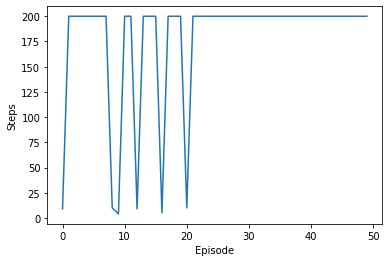

In [50]:
config_dict = {'batch_size':128,
            'hidden_size':256,
            'angle_threshold':20,
            'angle_threshold_start':15, #An episode starts only if the initial angle is within this.
            'velocity_threshold_start':0.6,
            'num_episodes':200,
            'num_episodes_test':50,

            'enable_disturbance':True,
            'disturbance_magnitude': 0.3,
            'ensure_safe_set':'safe',
            'safety_ratio':0.7,
            'wandb_log':False,
            'wandb_log_dist':False,
            'num_time_steps':200,
            'safe_action_epsilon':0.1,
            'angle_threshold_epsilon':10,
            'max_disturbance_steps':3}

info_dist = test_runs(env,agent,noise,config_dict)

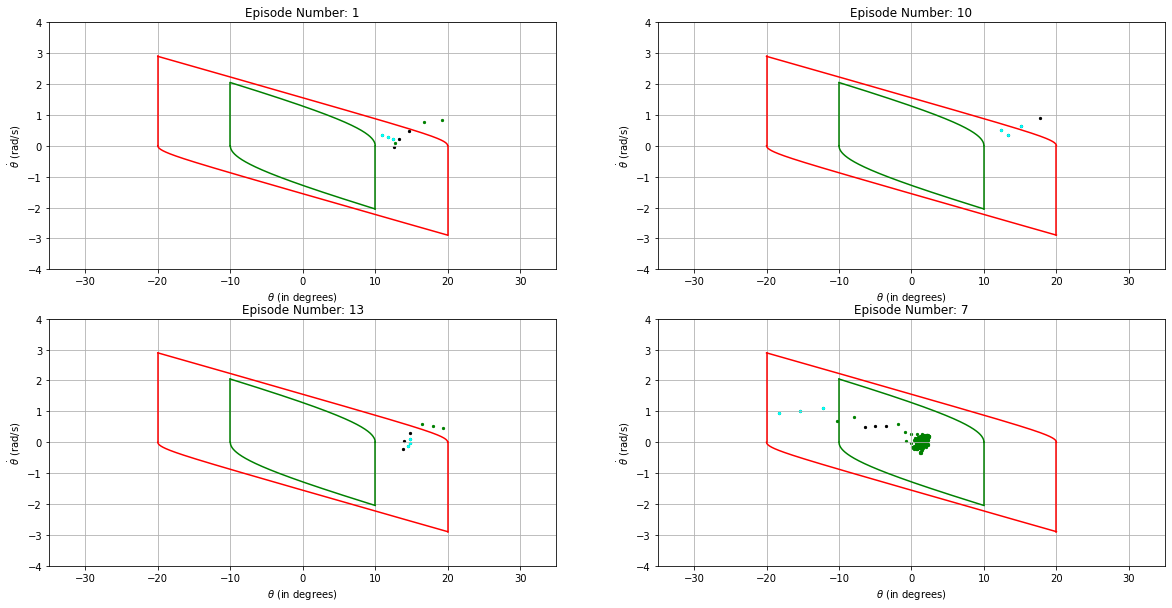

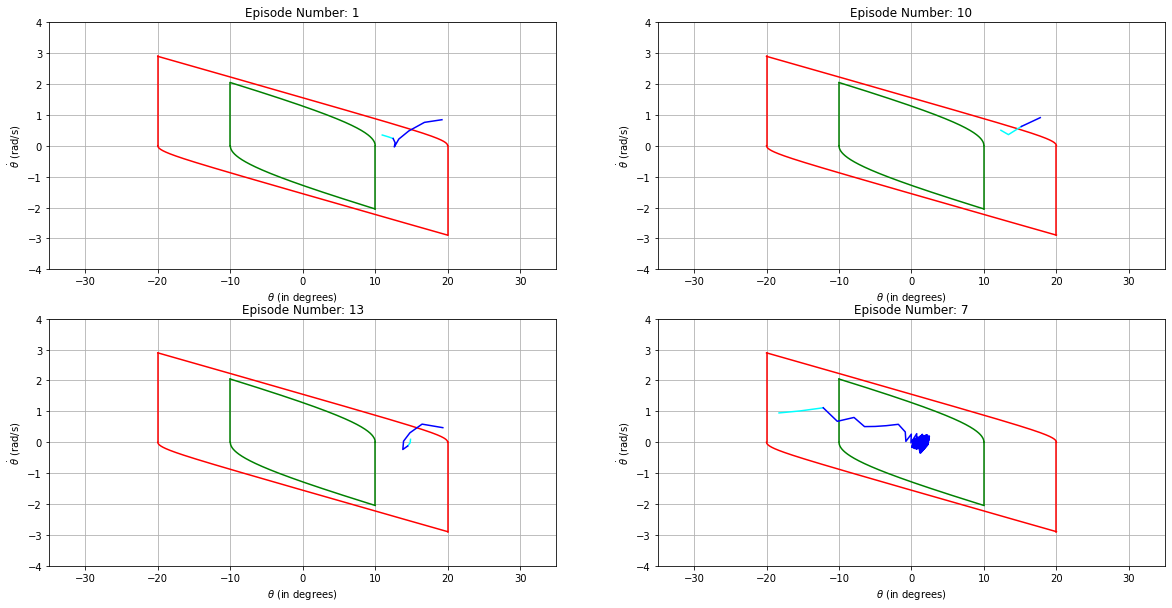

In [52]:
rows=2
cols=2
info = info_dist

episodes = [1,10,13,7] # the list of episodes to visualise 1-index

ax = plot_trajectory(info,rows,cols,scatter = True, episodes=episodes)
plt.show()

ax = plot_trajectory(info,rows,cols,scatter = False, episodes=episodes)
plt.show()

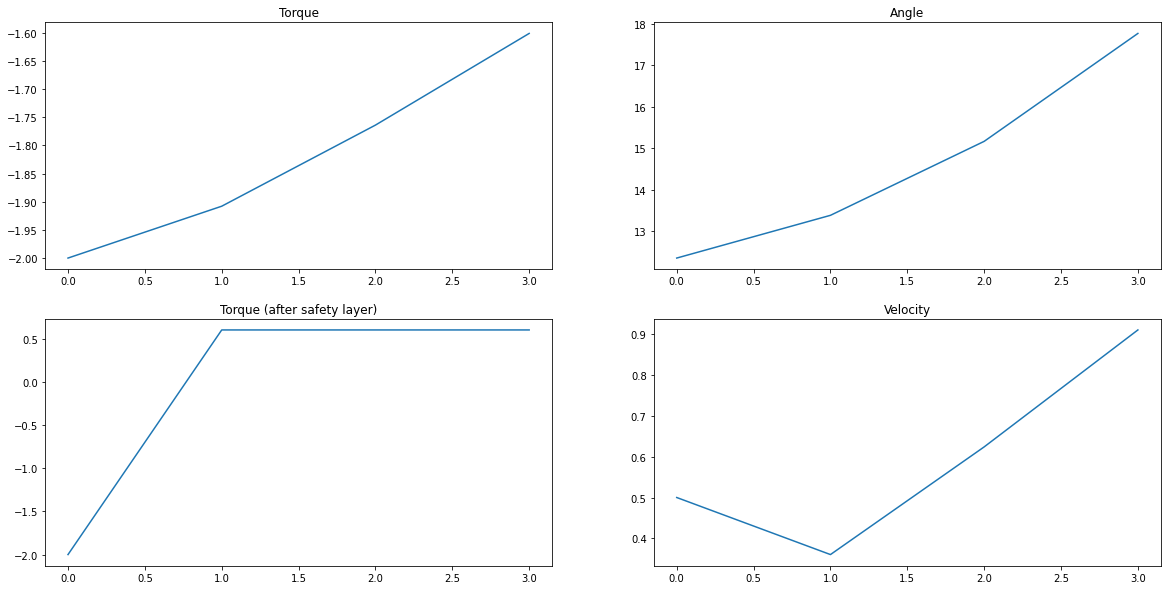

In [65]:
episode = 10
info = info_dist
window = [0,200]

plot_curves(info,episode,window)